## Neural Style Transfer Fast-NST

Early versions of NST treated the task as an optimization problem, requiring hundreds or thousands of iterations to perform style transfer on a single image. To tackle this inefficiency, researchers developed what’s referred to as "fast neural style transfer". Fast style transfer also uses deep neural networks but trains a standalone model to transform any image in a single, feed-forward pass. This Trained models can stylize any image with just one iteration through the network, rather than thousands.

In [42]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))



TF Version:  2.16.1
TF-Hub version:  0.16.1
Eager mode enabled:  True
GPU available:  []


In [45]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image


In [46]:
"""Loads and preprocesses images."""

@functools.lru_cache(maxsize=None)

def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

In [47]:
def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


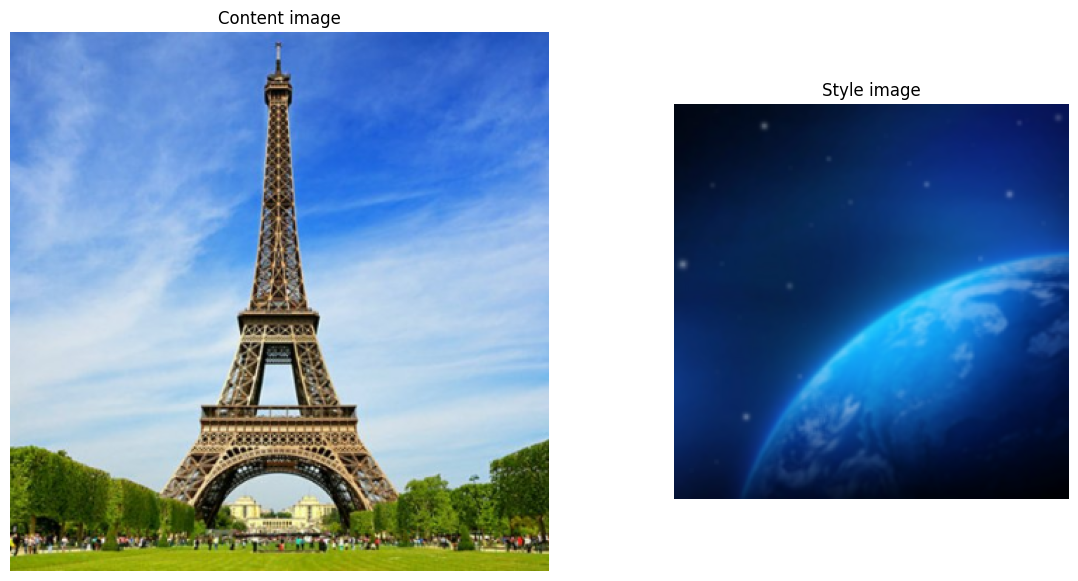

tf.Tensor(
[[[[0.         0.02352941 0.07058824]
   [0.         0.02352941 0.07058824]
   [0.00261438 0.02614379 0.075817  ]
   ...
   [0.03046365 0.07752247 0.32781968]
   [0.03408395 0.07722121 0.330816  ]
   [0.03408395 0.0772212  0.33212316]]

  [[0.         0.02352941 0.07058824]
   [0.         0.02352941 0.07058824]
   [0.00261438 0.02614379 0.075817  ]
   ...
   [0.03006536 0.07712419 0.32982773]
   [0.03318015 0.0763174  0.33165509]
   [0.03318015 0.0763174  0.33252656]]

  [[0.         0.02352941 0.07058824]
   [0.         0.02352941 0.07058824]
   [0.00261438 0.02614379 0.075817  ]
   ...
   [0.02630719 0.07554466 0.33129835]
   [0.02795139 0.07501021 0.32991222]
   [0.02795139 0.07501021 0.3299122 ]]

  ...

  [[0.01730905 0.07271019 0.2139497 ]
   [0.01687081 0.07166982 0.21114543]
   [0.01584401 0.06977156 0.20663278]
   ...
   [0.         0.00663467 0.01880787]
   [0.         0.00784314 0.0175994 ]
   [0.         0.00784314 0.01699346]]

  [[0.01520665 0.07126138 0.208579

In [49]:
# @title Load example images  { display-mode: "form" }

# content_image_url = 'https://www.codeproject.com/KB/GDI-plus/ImageProcessing2/img.jpg'  # @param {type:"string"}
# style_image_url = 'https://mcdn.wallpapersafari.com/medium/64/91/6kqfOi.jpg'  # @param {type:"string"}

# content_image_url = 'https://mcdn.wallpapersafari.com/medium/40/18/sif6qT.jpg'  # @param {type:"string"}
# style_image_url = 'https://mcdn.wallpapersafari.com/medium/33/23/HinN0k.jpg'  # @param {type:"string"}

content_image_url = 'https://www.planetware.com/photos-large/F/eiffel-tower.jpg'  # @param {type:"string"}
style_image_url = 'https://mcdn.wallpapersafari.com/medium/18/54/B1QKho.jpg'  # @param {type:"string"}


output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)

# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])
print(style_image)

In [50]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [51]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]



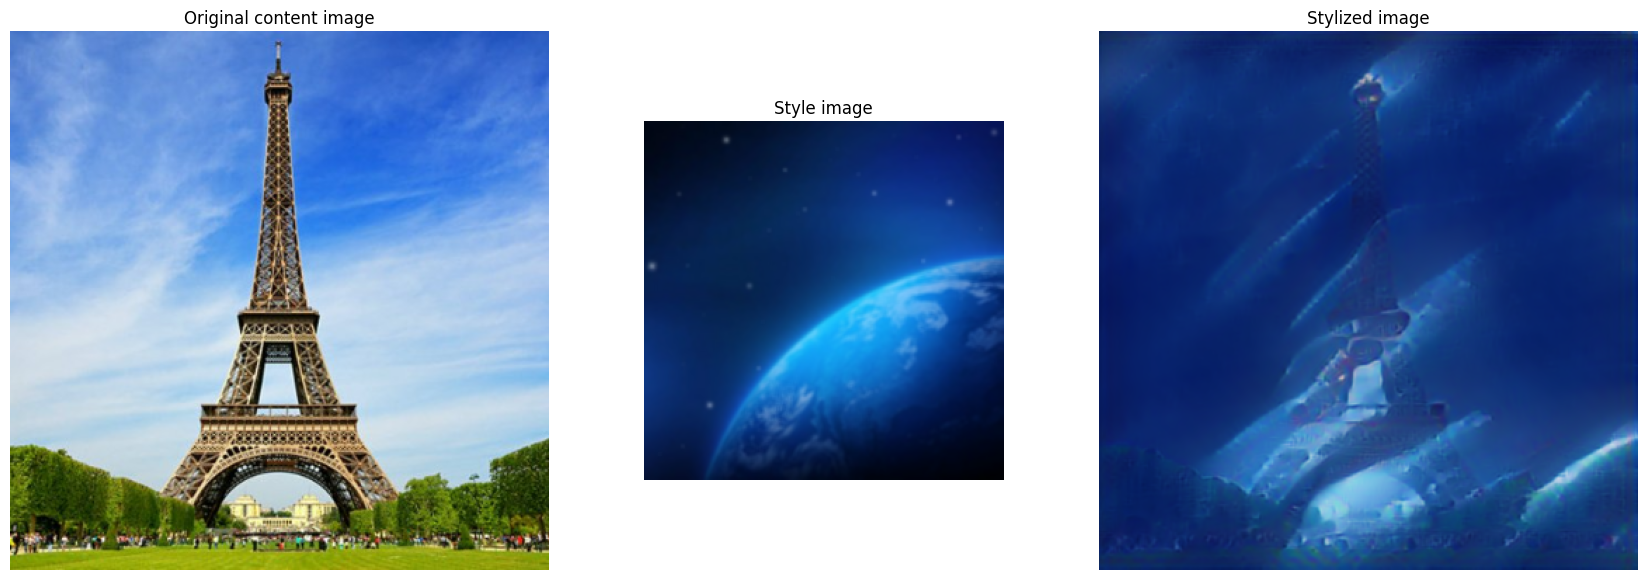

In [53]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])